In [32]:
import os
import cv2
# import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [33]:
# from google.colab import drive
# drive.mount('/content/drive')

In [34]:
# pip install opencv-python-headless

In [35]:
# pip install moviepy

In [36]:
# pip install -U scikit-learn scipy matplotlib

In [37]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [38]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 100

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = '/content/drive/MyDrive/ICIPE Research/Video_analytics/Videos/Video_dataset/100/Train'

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["Positive", "Negative"]

In [39]:
import cv2
import os
import numpy as np

def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    num_frames=50
   # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Ensure there are at least 100 frames in the video
    if video_frames_count < 100:
        print(f"Skipping video: {video_path} - Less than 100 frames.")
        video_reader.release()
        return None

    # Randomly select `num_frames` frames from the first 100 frames using stochastic sampling
    sampled_indices = np.random.choice(range(100), size=num_frames, replace=False)
    sampled_indices.sort()  # Sort sampled indices for order

    # Reset video reader
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, 0)

    # Read and process sampled frames
    for idx in sampled_indices:
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, idx)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 127.5
        normalized_frame -= 1

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()
    return frames_list


In [40]:
import os
import numpy as np

def create_dataset(save_path):
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Args:
        save_path: Path to save the extracted features, labels, and video file paths.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Check if the saved features file already exists
    if os.path.exists(save_path):
        print("Loading pre-extracted features...")
        # Load the saved features
        data = np.load(save_path)
        features = data['features']
        labels = data['labels']
        video_files_paths = data['video_files_paths']
    else:
        # Iterating through all the classes mentioned in the classes list
        for class_index, class_name in enumerate(CLASSES_LIST):

            # Display the name of the class whose data is being extracted.
            print(f'Extracting Data of Class: {class_name}')

            # Get the list of video files present in the specific class name directory.
            files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

            # Iterate through all the files present in the files list.
            for file_name in files_list:

                # Get the complete video path.
                video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

                # Extract the frames of the video file.
                frames = frames_extraction(video_file_path)
                num_frames=50
                # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
                # So ignore the vides having frames less than the SEQUENCE_LENGTH.
                if len(frames) == num_frames:

                    # Append the data to their respective lists.
                    features.append(frames)
                    labels.append(class_index)
                    video_files_paths.append(video_file_path)

        # Converting the list to numpy arrays
        features = np.asarray(features)
        labels = np.array(labels)

        # Save the extracted features, labels, and video file paths to disk
        np.savez(save_path, features=features, labels=labels, video_files_paths=video_files_paths)
        print("Extracted features saved successfully.")

    # Return the features, class index, and video file path.
    return features, labels, video_files_paths


In [41]:
# Path to save the extracted features
save_path = "/content/drive/MyDrive/ICIPE Research/Video_analytics/Videos/Extracted_Features/stochastic/50train.npz"

In [42]:

features, labels, video_files_paths = create_dataset(save_path)

Loading pre-extracted features...


In [43]:
one_hot_encoded_train_labels = to_categorical(labels)

In [44]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 100

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = '/content/drive/MyDrive/ICIPE Research/Video_analytics/Videos/Video_dataset/100/Val'

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["Positive", "Negative"]

In [45]:
# Path to save the extracted features
save_path = "/content/drive/MyDrive/ICIPE Research/Video_analytics/Videos/Extracted_Features/stochastic/50st_features.npz"

In [46]:
# Create the dataset.
features_val, labels_val, video_files_paths_val = create_dataset(save_path)

Loading pre-extracted features...


In [47]:
one_hot_encoded_val_labels = to_categorical(labels_val)

In [48]:
features_train, features_test, labels_train, labels_test = features, features_val, one_hot_encoded_train_labels, one_hot_encoded_val_labels

In [49]:
features_train.shape

(1455, 50, 64, 64, 3)

In [50]:
import keras
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import Dense, Input, RepeatVector, Dropout
from keras.models import Model
from keras.optimizers import Nadam
from keras.layers import LSTM
# from keras.layers.wrappers import TimeDistributed
# from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from keras.layers import TimeDistributed, GRU, Dense, Dropout

In [51]:
no_of_channels = 3
timesteps = 50
video_input = Input(shape=(timesteps,
                           IMAGE_HEIGHT,
                            IMAGE_WIDTH,
                            no_of_channels))

In [52]:
mobilenet = MobileNetV2(input_shape=(IMAGE_HEIGHT,
                              IMAGE_WIDTH,
                              no_of_channels),
                 weights="imagenet",
                 include_top=False)

In [53]:
mobilenet_output = tf.keras.layers.GlobalAveragePooling2D()(mobilenet.output)

In [54]:
mobilenet_model = Model(inputs=mobilenet.input, outputs=mobilenet_output)

In [55]:
mobilenet_model.trainable = False

In [56]:
video_frames_encoded = tf.keras.layers.TimeDistributed(mobilenet_model)(video_input)

In [57]:
no_of_classes = 2

In [58]:
video_frames_encoded_sequence = tf.keras.layers.LSTM(512, return_sequences=True)(video_frames_encoded)
video_frames_encoded_sequence = Dropout(0.5)(video_frames_encoded_sequence)
lstm2 = tf.keras.layers.LSTM(256)(video_frames_encoded_sequence)

In [59]:
lstm2 = Dropout(0.5)(lstm2)

In [60]:
# dense_layer1 = Dense(512, activation="relu")(video_frames_encoded_sequence)
# dense_layer1 = Dropout(0.5)(dense_layer1)

dense_layer1 = Dense(128, activation="relu")(lstm2)
dense_layer1 = Dropout(0.25)(dense_layer1)

outputs = Dense(no_of_classes, activation="sigmoid")(dense_layer1)
model = Model([video_input], outputs)

In [61]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 64, 64, 3)]   0         
                                                                 
 time_distributed_1 (TimeDi  (None, 50, 1280)          2257984   
 stributed)                                                      
                                                                 
 lstm_4 (LSTM)               (None, 50, 512)           3672064   
                                                                 
 dropout_4 (Dropout)         (None, 50, 512)           0         
                                                                 
 lstm_5 (LSTM)               (None, 256)               787456    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                           

In [62]:
optimizer = Nadam(learning_rate=0.001,
                  beta_1=0.9,
                  beta_2=0.999,
                  epsilon=1e-08)

In [63]:
model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [64]:
early_stopping_callback=EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=5,
)

In [65]:
callbacks = [early_stopping_callback]

In [66]:
features_train.shape

(1455, 50, 64, 64, 3)

In [67]:
labels_train.shape

(1455, 2)

In [68]:
# Start Training
model_training_history = model.fit(x = features_train,
                                   y = labels_train,
                                   epochs = 50,
                                   batch_size = 4,
                                   callbacks = callbacks,
                                   shuffle = True,
                                   validation_split = 0.2)

Epoch 1/50
291/291 [==============================] - 21s 36ms/step - loss: 0.5058 - accuracy: 0.7629 - val_loss: 0.1352 - val_accuracy: 0.9897
Epoch 2/50
291/291 [==============================] - 7s 23ms/step - loss: 0.3328 - accuracy: 0.8625 - val_loss: 0.1464 - val_accuracy: 0.9416
Epoch 3/50
291/291 [==============================] - 6s 22ms/step - loss: 0.2645 - accuracy: 0.8952 - val_loss: 0.4705 - val_accuracy: 0.7973
Epoch 4/50
291/291 [==============================] - 6s 22ms/step - loss: 0.1992 - accuracy: 0.9210 - val_loss: 0.3497 - val_accuracy: 0.8591
Epoch 5/50
291/291 [==============================] - 7s 22ms/step - loss: 0.1941 - accuracy: 0.9270 - val_loss: 0.0627 - val_accuracy: 0.9828
Epoch 6/50
291/291 [==============================] - 7s 23ms/step - loss: 0.1474 - accuracy: 0.9459 - val_loss: 0.1247 - val_accuracy: 0.9416
Epoch 7/50
291/291 [==============================] - 7s 23ms/step - loss: 0.1059 - accuracy: 0.9639 - val_loss: 0.3958 - val_accuracy: 0.845

In [69]:
model_evaluation_history = model.evaluate(features_test, labels_test)

12/12 [==============================] - 2s 124ms/step - loss: 0.1732 - accuracy: 0.9448


In [82]:
# Get the loss and accuracy from model_evaluation_history.
save_location = '/content/drive/MyDrive/ICIPE Research/Video_analytics/Trained_models/'
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'lstm_lstm_50_stochastic_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
full_save_path = save_location + model_file_name

# Save your Model.
model.save(full_save_path)

  saving_api.save_model(



In [71]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

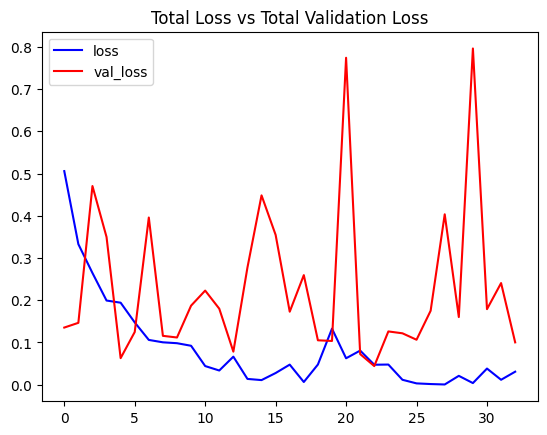

In [72]:
# Visualize the training and validation loss metrices.
plot_metric(model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

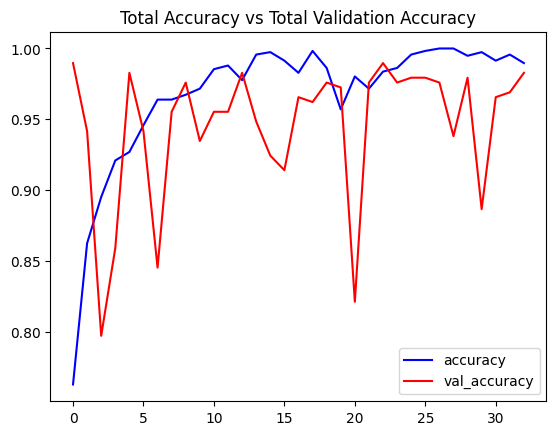

In [73]:
# Visualize the training and validation accuracy metrices.
plot_metric(model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [74]:
labels_pred = model.predict(features_test)

12/12 [==============================] - 3s 109ms/step


In [75]:
labels_pred = np.argmax(labels_pred, axis = 1)
labels_test = np.argmax(labels_test, axis = 1)

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_metric(measure_name_1, measure_name_2, plot_title):


  measure_value_1 = model_training_history.history[measure_name_1]
  measure_value_2 = model_training_history.history[measure_name_2]
  epochs = range(len(measure_value_1))

  plt.plot(epochs, measure_value_1, 'blue', label = measure_name_1)
  plt.plot(epochs, measure_value_2, 'red', label = measure_name_2)

  plt.title(str(plot_title))
  plt.legend()

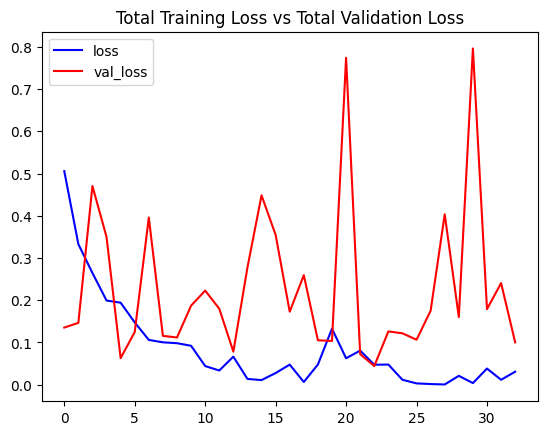

In [77]:
plot_metric('loss', 'val_loss', 'Total Training Loss vs Total Validation Loss')

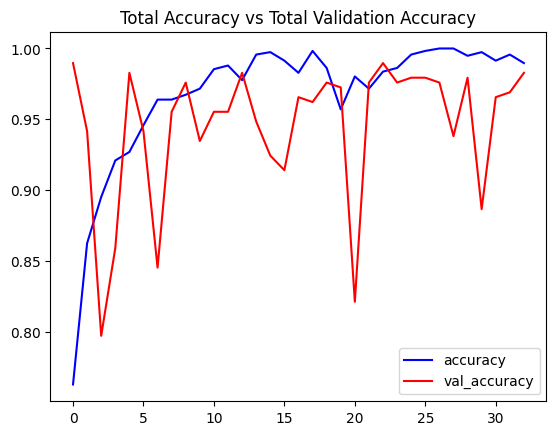

In [78]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

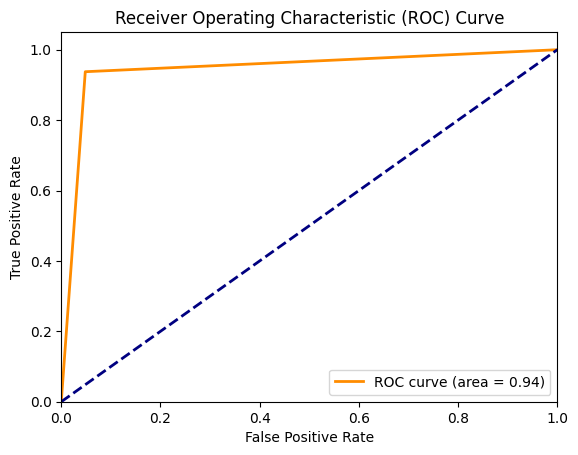

In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have features_test and y_labels available
# y_pred is the predicted probabilities from the model
# y_pred = model.predict(features_test)

# Compute fpr, tpr, thresholds and AUC
fpr, tpr, thresholds = roc_curve(labels_test, labels_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

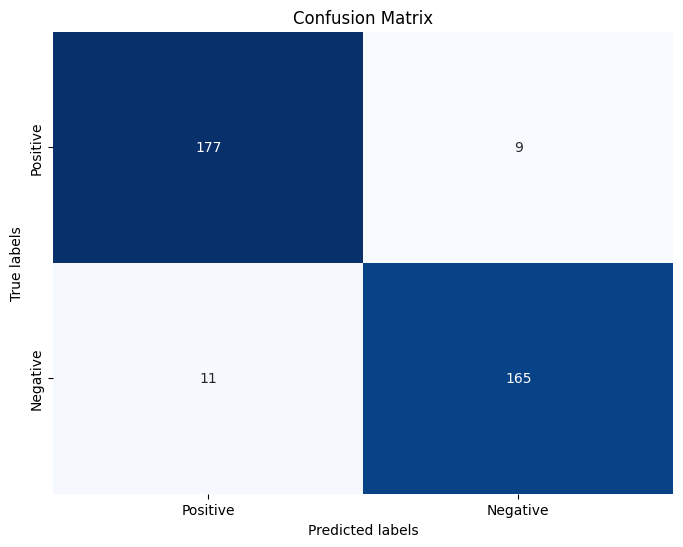

In [80]:
CLASSES_LIST = ["Positive", "Negative"]

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have y_true (true labels) and y_pred (predicted labels) available

# Compute confusion matrix
cm = confusion_matrix(labels_test, labels_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [81]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(labels_test, labels_pred)
recall = recall_score(labels_test, labels_pred)
f1 = f1_score(labels_test, labels_pred)

print ("Precision = ", precision)
print ("Recall = ", recall)
print ("f1 = ", f1)

Precision =  0.9482758620689655
Recall =  0.9375
f1 =  0.9428571428571428


## Try with the Features with augmentation